# Analyze variable distributions

In this step we search for insights about the attack variables.

In [1]:
import json
import os
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()

%matplotlib inline

plt.style.use("seaborn")

## Load the data

In [2]:
data_directory = os.path.join("..", "..", "..", "data")

In [3]:
results_file_path = os.path.join(data_directory, "suppression_results.json")
if not os.path.exists(results_file_path):
    with tarfile.open(os.path.join(data_directory, "suppression_results.tar.xz"), "r", encoding="utf-8") as compressed_file:
        compressed_file.extract("suppression_results.json", data_directory)

In [4]:
with open(results_file_path, "r", encoding="utf-8") as results_file:
    results = []
    line = results_file.readline().strip()
    while line != "":
        results.append(json.loads(line))
        line = results_file.readline().strip()

In [5]:
campaigns_file_path = os.path.join(data_directory, "suppression_campaigns.json")
if not os.path.exists(campaigns_file_path):
    with tarfile.open(os.path.join(data_directory, "suppression_campaigns.tar.xz"), "r", encoding="utf-8") as compressed_file:
        compressed_file.extract("suppression_campaigns.json", data_directory)

In [6]:
with open(campaigns_file_path, "r", encoding="utf-8") as campaigns_file:
    campaigns = []
    line = campaigns_file.readline().strip()
    while line != "":
        campaigns.append(json.loads(line))
        line = campaigns_file.readline().strip()

## Validation

In [7]:
print("# blocks (results)", len(results))

# blocks (results) 1485


In [8]:
print("# transactions (results)", sum([len(result["transactions"]) for result in results]))

# transactions (results) 9135


In [9]:
print("# blocks (campaigns)",
      sum([campaign["nr_of_blocks"] for campaign in campaigns]))

# blocks (campaigns) 1485


In [10]:
print("# transactions (campaigns)",
      sum([campaign["nr_of_transactions"] for campaign in campaigns]))

# transactions (campaigns) 9135


A round has a withdrawal transaction if and only if it is the last round of a successful campaign

In [11]:
for campaign in campaigns:
    # the last round has a withdrawal transaction if and only if it is from a successful campaign
    assert campaign["successful"] == ("withdrawal_transaction" in campaign["rounds"][-1])
    
    # the other rounds never have a withdrawal transaction
    for round_ in campaign["rounds"][:-1]:
        assert "withdrawal_transaction" not in round_
        
    # check that the stuffing starts at the same time or after the investment
    for round_ in campaign["rounds"]:
        assert round_["investment_transaction"]["blockNumber"] <= round_["first_block"]
        
    # the bot is always the same
    for round_ in campaign["rounds"]:
        for transaction in round_["transactions"]:
            assert transaction["to"] == campaign["bot_address"]

## Collect into data frames

In [12]:
number_of_rounds_per_campaign = []
number_of_blocks_per_campaign = []
number_of_transactions_per_campaign = []
campaign_was_successful = []
cost_per_campaign = []
profit_per_campaign = []
type_per_campaign = []

number_of_blocks_per_round = []
number_of_transactions_per_round = []
round_from_a_successful_campaign = []
round_was_successful = []
cost_per_round = []
profit_per_round_from_campaign = []

# compute this
wait_blocks_per_round = []

for campaign in campaigns:
    number_of_rounds_per_campaign.append(len(campaign["rounds"]))
    number_of_blocks_per_campaign.append(campaign["nr_of_blocks"])
    number_of_transactions_per_campaign.append(campaign["nr_of_transactions"])
    campaign_was_successful.append(campaign["successful"])
    cost_per_campaign.append(campaign["costs_usd"])
    profit_per_campaign.append(campaign["profit_usd"])
    type_per_campaign.append(campaign["suppression_type"])
    
    for round_ in campaign["rounds"]:
        number_of_blocks_per_round.append(round_["nr_of_blocks"])
        number_of_transactions_per_round.append(round_["nr_of_transactions"])
        round_from_a_successful_campaign.append(campaign["successful"])
        round_was_successful.append("withdrawal_transaction" in round_)
        cost_per_round.append(round_["costs_usd"])
        
        # only assign to last round
        profit_per_round_from_campaign.append(campaign["profit_usd"])

In [13]:
df_campaigns = pd.DataFrame({
    "Number of rounds": number_of_rounds_per_campaign,
    "Number of blocks": number_of_blocks_per_campaign,
    "Number of transactions": number_of_transactions_per_campaign,
    "Successful": campaign_was_successful,
    "Cost": cost_per_campaign,
    "Profit": profit_per_campaign,
    "Type": type_per_campaign,
})

In [14]:
df_rounds = pd.DataFrame({
    "Number of blocks": number_of_blocks_per_round,
    "Number of transactions": number_of_transactions_per_round,
    "From Successful Campaign": round_from_a_successful_campaign,
    "Successful": round_was_successful,
    "Cost": cost_per_round,
    "Profit": profit_per_round_from_campaign,
})

## Save latex tables for the publication

In [15]:
df_attacks = df_campaigns[[
        "Cost",
        "Profit",
        "Number of rounds",
        "Number of blocks",
        "Number of transactions",
    ]].rename(columns={
        "Number of rounds": "Rounds",
        "Number of blocks": "Blocks",
        "Number of transactions": "Transactions",
    })

df_attacks.describe().style.format("{:.2f}")

,Cost,Profit,Rounds,Blocks,Transactions
count,50.00,50.00,50.00,50.00,50.00
mean,2349.65,20725.24,6.62,29.70,182.70
std,3331.21,113598.58,12.86,50.77,456.91
min,4.67,-10741.12,1.00,2.00,6.00
25%,221.87,-1893.26,1.00,4.00,12.50
50%,896.68,-284.81,2.00,10.00,33.50
75%,2719.69,-14.93,4.75,21.50,88.75
max,10741.12,791211.86,66.00,233.00,2664.00


In [16]:
df_attacks.to_csv(os.path.join(data_directory, "suppression_attacks.csv"), index=False)

In [17]:
latex = df_attacks.to_latex(index=True, formatters={
        "Rounds": "{:,.2f}".format,
        "Blocks": "{:,.2f}".format,
        "Transactions": "{:,.2f}".format,
        "Cost": "{:,.2f}".format,
        "Profit": "{:,.2f}".format,
    })

with open(os.path.join(data_directory, "suppression_attack_stats.tex"), "w") as latex_file:
    latex_file.write(latex)

In [18]:
df_strategies = pd.crosstab(df_campaigns.Type, df_campaigns.Successful, margins=True)
df_strategies

Successful,False,True,All
Type,,,
assert,18,2,20
controlled_gas_loop,10,8,18
out_of_gas_loop,9,3,12
All,37,13,50


In [19]:
latex = df_strategies.to_latex(index=True)

with open(os.path.join(data_directory, "suppression_strategies_stats.tex"), "w") as latex_file:
    latex_file.write(latex)

## Other stats

### Common plots

In [20]:
def plot_success_distribution(data):
    plt.figure()
    sns.countplot(data=data, x="Successful")
    plt.tight_layout()
    plt.show()

In [21]:
def plot_variable_distribution_by_success(data, variable):
    plt.figure()
    sns.ecdfplot(data=data, x=variable, hue="Successful")
    plt.yticks([0, .25, .5, .75, 1])
    plt.tight_layout()
    plt.show()

In [22]:
def plot_two_variables(data, x_variable, y_variable, only_successful=True):
    if only_successful:
        data = data[data["Successful"]]
        
    plt.figure()
    sns.scatterplot(data=data, x=x_variable, y=y_variable)
    plt.tight_layout()
    plt.show()
    
    print("Correlation: {:.2f}".format(data[x_variable].corr(data[y_variable])))

### Campaigns

In [23]:
df_campaigns.describe()

,Number of rounds,Number of blocks,Number of transactions,Cost,Profit
count,50.000000,50.0000,50.000000,50.000000,50.000000
mean,6.620000,29.7000,182.700000,2349.651629,20725.235617
std,12.863316,50.7721,456.908567,3331.210711,113598.580242
min,1.000000,2.0000,6.000000,4.667298,-10741.119731
25%,1.000000,4.0000,12.500000,221.871667,-1893.262302
50%,2.000000,10.0000,33.500000,896.681002,-284.811519
75%,4.750000,21.5000,88.750000,2719.694211,-14.930519
max,66.000000,233.0000,2664.000000,10741.119731,791211.860156


### Success distribution

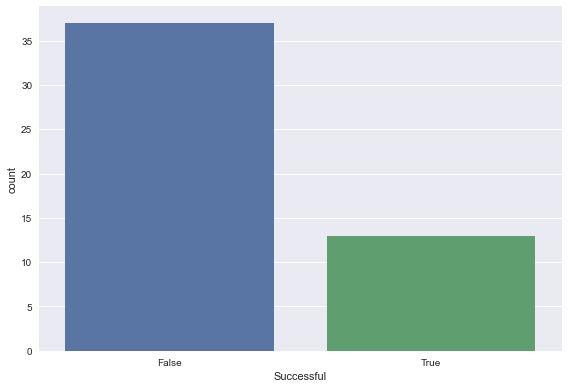

In [24]:
plot_success_distribution(df_campaigns)

### Empirical cumulative distribution function by success

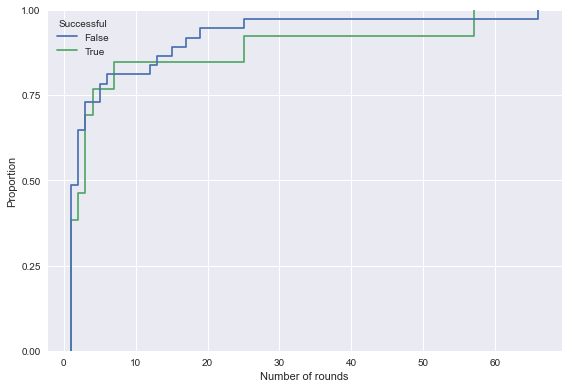

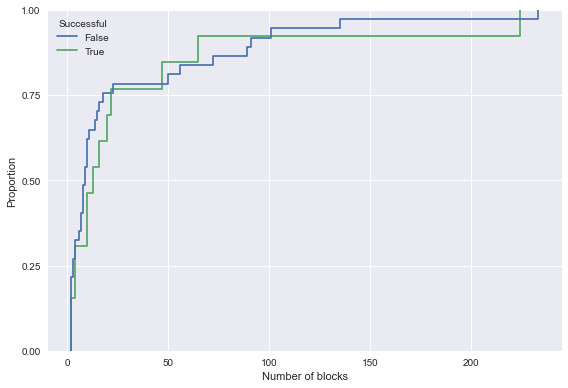

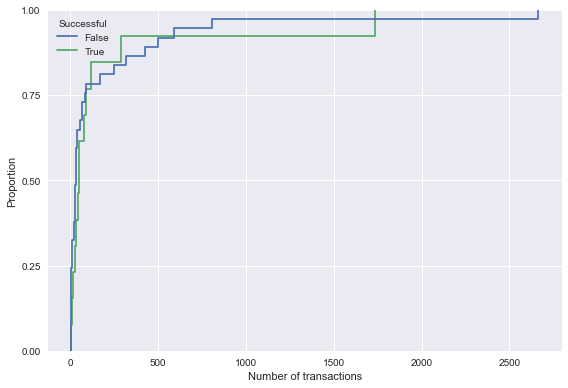

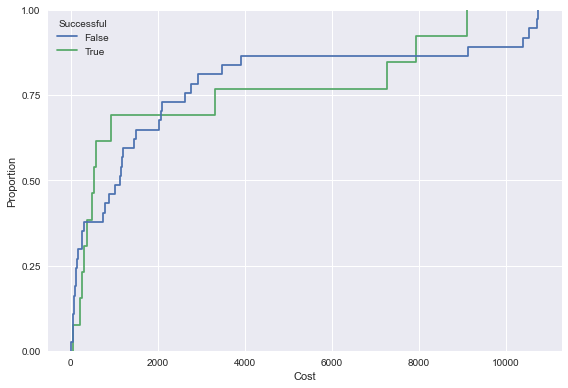

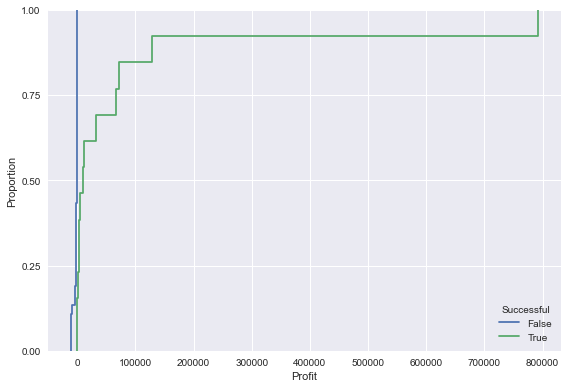

In [25]:
for variable, variable_type in zip(df_campaigns.columns, df_campaigns.dtypes):
    if variable_type in [np.int32, np.int64, np.float32, np.float64]:
        plot_variable_distribution_by_success(df_campaigns, variable)

### Profit correlations

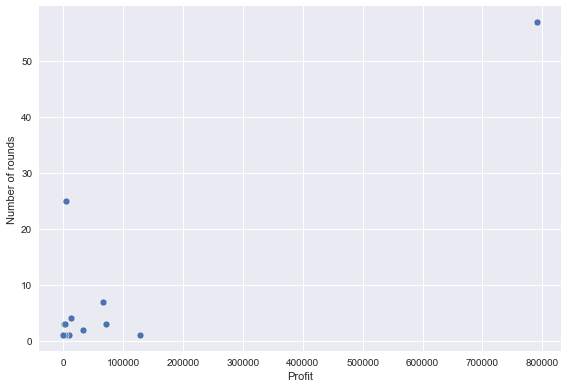

Correlation: 0.89


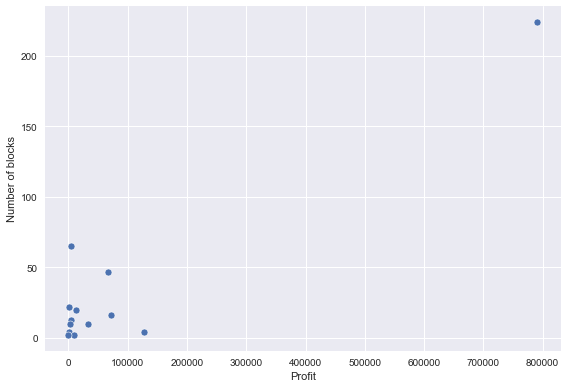

Correlation: 0.93


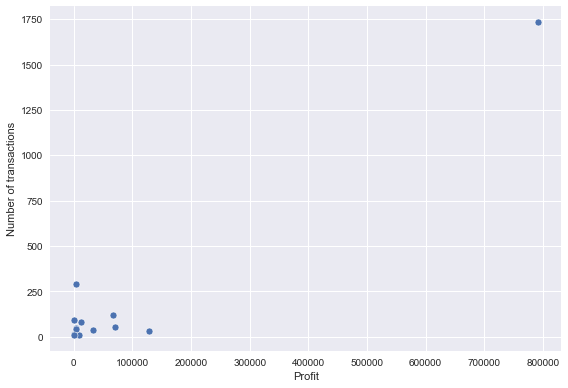

Correlation: 0.97


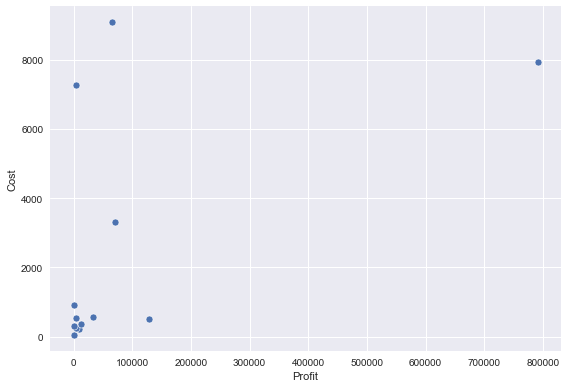

Correlation: 0.52


In [26]:
for variable, variable_type in zip(df_campaigns.columns, df_campaigns.dtypes):
    if variable != "Profit" and variable_type in [np.int32, np.int64, np.float32, np.float64]:
        plot_two_variables(df_campaigns, "Profit", variable, only_successful=True)

### Rounds

In [27]:
df_rounds.describe()

,Number of blocks,Number of transactions,Cost,Profit
count,331.000000,331.000000,331.000000,331.000000
mean,4.486405,27.598187,352.203801,134700.189835
std,4.102730,26.058766,677.043076,300293.452994
min,1.000000,2.000000,2.192535,-10741.119731
25%,2.000000,10.000000,72.951907,-10707.400344
50%,3.000000,18.000000,146.360768,-2068.114898
75%,5.000000,36.000000,292.581872,4349.045529
max,39.000000,177.000000,5994.024595,791211.860156


### Success distribution

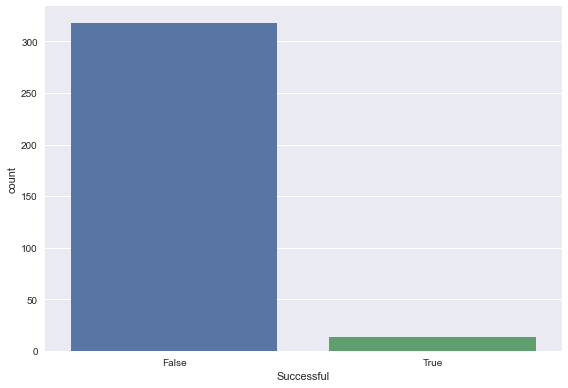

In [28]:
plot_success_distribution(data=df_rounds)

### Empirical cumulative distribution function by success

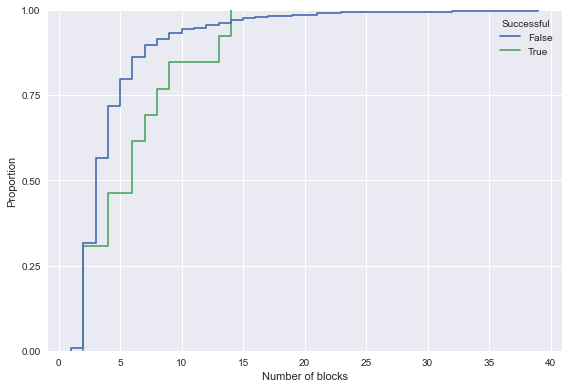

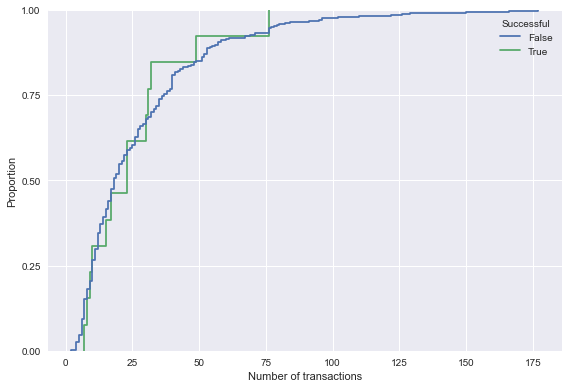

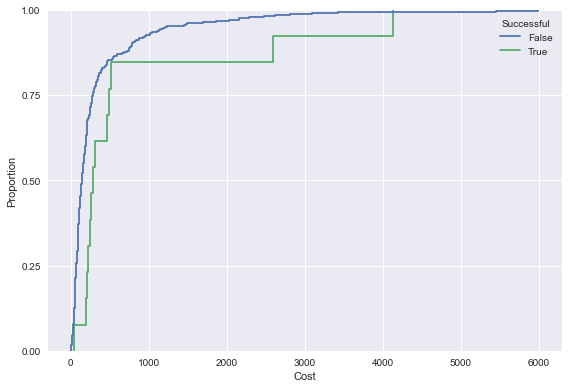

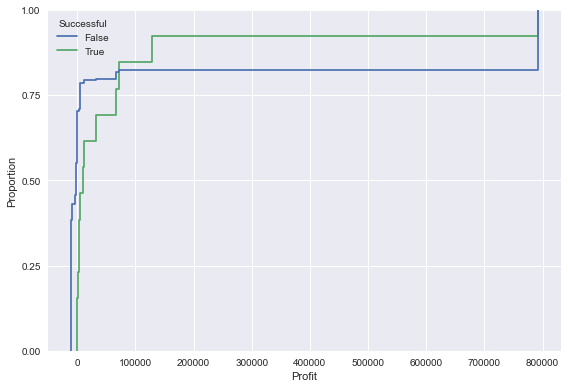

In [29]:
for variable, variable_type in zip(df_rounds.columns, df_rounds.dtypes):
    if variable_type in [np.int32, np.int64, np.float32, np.float64]:
        plot_variable_distribution_by_success(df_rounds, variable)

### Profit correlations

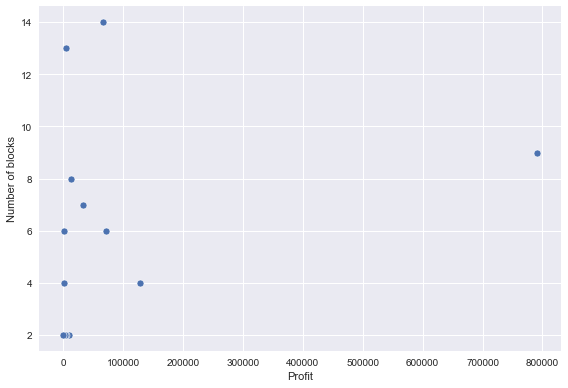

Correlation: 0.24


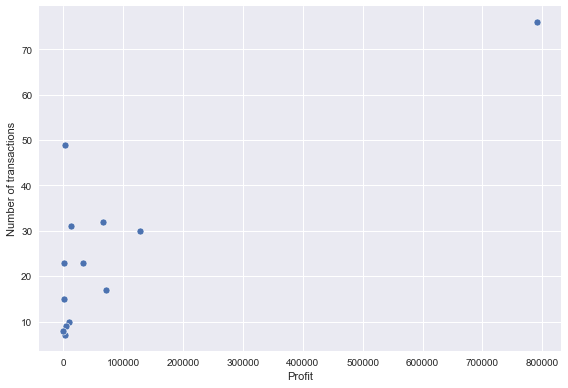

Correlation: 0.80


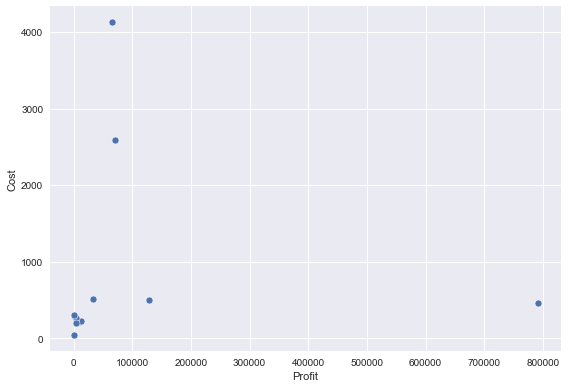

Correlation: 0.02


In [30]:
for variable, variable_type in zip(df_rounds.columns, df_rounds.dtypes):
    if variable != "Profit" and variable_type in [np.int32, np.int64, np.float32, np.float64]:
        plot_two_variables(df_rounds, "Profit", variable, only_successful=True)

### All campaign variable correlations

In [31]:
df_campaigns[[
        "Cost",
        "Profit",
        "Number of rounds",
        "Number of blocks",
        "Number of transactions",
    ]].rename(columns={
        "Number of rounds": "Rounds",
        "Number of blocks": "Blocks",
        "Number of transactions": "Transactions",
    }).corr().style.format("{:.2f}").background_gradient(cmap='coolwarm')

,Cost,Profit,Rounds,Blocks,Transactions
Cost,1.00,0.23,0.72,0.71,0.59
Profit,0.23,1.00,0.53,0.52,0.45
Rounds,0.72,0.53,1.00,0.94,0.93
Blocks,0.71,0.52,0.94,1.00,0.91
Transactions,0.59,0.45,0.93,0.91,1.00
